In [1]:
using ModelingToolkit, Sophon, DomainSets, TaylorDiff
using Optimization, OptimizationOptimJL

@parameters x y
@variables u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2

eq = Dxx(u(x, y)) + Dyy(u(x, y)) ~ 0

bcs = [u(-1, y) ~ 1,
       u(1, y) ~ 0,
       u(x, -1) ~ 50/75f0,
       u(x, 1) ~ 0]


# Space and time domains
domains = [x ∈ Interval(-1.0f0, 1.0f0),
           y ∈ Interval(-1.0f0, 1.0f0)]

@named pde_system = PDESystem([eq], bcs, domains, [x, y], [u(x, y)])

PDESystem
Equations: Equation[Differential(y)(Differential(y)(u(x, y))) + Differential(x)(Differential(x)(u(x, y))) ~ 0]
Boundary Conditions: Equation[u(-1, y) ~ 1, u(1, y) ~ 0, u(x, -1) ~ 0.6666667, u(x, 1) ~ 0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, -1.0..1.0), Symbolics.VarDomainPairing(y, -1.0..1.0)]
Dependent Variables: Num[u(x, y)]
Independent Variables: Num[x, y]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [9]:
chain = FullyConnected(2, 1, tanh; hidden_dims=20, num_layers=6)
pinn = PINN(chain)
sampler = QuasiRandomSampler(2000, 200)
strategy = NonAdaptiveTraining(1, 10)
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [1.785988211631775 2.0353808403015137; -1.0055307149887085 2.0000569820404053; … ; 1.0742686986923218 1.3498508930206299; -1.8327629566192627 -0.22256167232990265], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.034059591591358185 0.09580829739570618 … -0.1676701307296753 0.22639897465705872; -0.09246215969324112 0.1435195356607437 … 0.31235405802726746 0.42554712295532227; … ; -0.4846073091030121 -0.14630310237407684 … 0.38982880115509033 -0.00897128414362669; -0.13879439234733582 -0.07175619155168533 … 0.45273205637931824 -0.6206035614013672], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.5897958874702454 -0.16423197090625763 … 0.504484236240387 0.02170884981751442; -0.35960790514945984 -0.5533625483512878 … 0.6286630034446716 0.594576358795166; … ; -0.0015761516988277435 0.3804090619087219 … 0.25001001358032227 0.5216645002365112; -0.19082678854465485 -0.42941221594810486 … 

In [12]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

using OptimizationOptimisers
res = Optimization.solve(prob, BFGS(); maxiters=2000, callback=callback)

Loss: 15721.0241198583


Loss: 0.1911371551573027


Loss: 0.07258512072833243


Loss: 0.03513444521280662


Loss: 0.020551796812463375


Loss: 0.016053943492435316


Loss: 0.011575035833083983


Loss: 0.007367341240645806


Loss: 0.005679734442557418


Loss: 0.004714030372409405


Loss: 0.004173310765412813


Loss: 0.0037256233728691812


Loss: 0.0032222933634152794


Loss: 0.0029396828679481768


Loss: 0.0026750841380996228


Loss: 0.0024274882753206337


Loss: 0.0022569883983238866


Loss: 0.0021325299289014815


Loss: 0.0019841642079755166


Loss: 0.0018251750869762969


Loss: 0.0016221050867678611


u: ComponentVector{Float64}(layer_1 = (weight = [0.7871095983543642 0.7386624462950534; 0.0550790481353806 7.8614450457418545; … ; 3.9511709102028743 -4.669365804811651; 0.09303531361678814 -0.9299991142565218], bias = [-2.5512771380773827; 8.946141484288878; … ; -9.289764930503495; 2.0630924768183783;;]), layer_2 = (weight = [-1.4053556524553301 -0.03648619340639301 … -0.6471662690770277 -3.2884070736535027; -2.7069173933827413 0.9074577860694791 … 0.3754118103950721 5.766176734620164; … ; -1.9681595297897212 -2.591022542868601 … 0.7788763038995731 -6.8013154266256945; -7.903065029533851 0.9796485109986837 … 5.979449453991405 -2.1699430872573564], bias = [-1.019415032089933; 0.8402231283410719; … ; 2.8585037258229815; 2.1358413707333006;;]), layer_3 = (weight = [0.9425879813557904 -0.9109336736837961 … 1.3343284164543554 -0.9772853071721523; 0.7936392923599057 -1.34244714727575 … 0.8551917008204198 -0.26501418744002486; … ; -0.44410280003693975 3.1244155219978653 … -0.4961735233097529

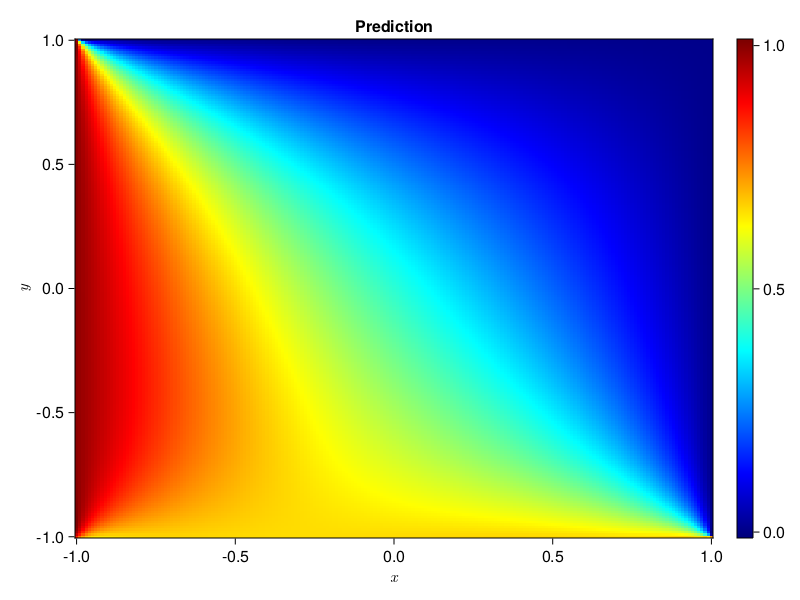

In [14]:
using CairoMakie, MakiePublication

phi = pinn.phi
xs, ys = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"x", ylabel=L"y", title="Prediction")
u_pred = [sum(pinn.phi([x, y], res.u)) for x in xs, y in ys]
fig, ax, hm = heatmap(xs, ys, u_pred, axis=axis, colormap=:jet)
Colorbar(fig[1,2], hm)
fig